# Nature Conservancy Fish Classification - Bounding Box End-to-End Model

### Imports & environment

In [1]:
import os
from PIL import Image

from keras.callbacks import ModelCheckpoint
from keras.layers import GlobalAveragePooling2D, AveragePooling2D, Activation, Input, Flatten
from keras.optimizers import Adam
from keras.models import Sequential
from keras.preprocessing.image import load_img, img_to_array

from vgg16bn import Vgg16BN as VggConv

from utils import * 
from models import Vgg16BN, Inception, Resnet50
from glob import iglob

ROOT_DIR = os.getcwd()
DATA_HOME_DIR = ROOT_DIR + '/data'
%matplotlib inline

Using Theano backend.
Using gpu device 0: GeForce GTX 980M (CNMeM is enabled with initial size: 90.0% of memory, cuDNN 5105)


### Config & Hyperparameters

In [10]:
# paths
data_path = DATA_HOME_DIR + '/cropped/' 
split_train_path = data_path + '/train/'
valid_path = data_path + '/valid/'
test_path = DATA_HOME_DIR + '/test/'
saved_model_path = ROOT_DIR + '/models/bb_end_to_end/'
submission_path = ROOT_DIR + '/submissions/bb_end_to_end/'
fish_detector_path = ROOT_DIR + '/models/fish_detector_480x270/0.03-loss_2epoch_480x270_0.3-dropout_0.001-lr_vggbn.h5'
bb_regressor_path = 'models/bb_regressor/360x640/loss-408.47_vgg16_bn.h5'

# data
batch_size = 16
im_size = (224, 224)  # (ht, wt); only 299x299 for inception
cropsize = 224
nb_split_train_samples = 2797
nb_valid_samples = 500
nb_test_samples = 1000
classes = ["ALB", "BET", "DOL", "LAG", "OTHER", "SHARK", "YFT"]
nb_classes = len(classes)

# model
nb_runs = 1
nb_epoch = 25
nb_aug = 1
dropout = 0.5
lr = 0.01           
clip = 0.01
archs = ["vggbn"]

models = {
    "vggbn": Vgg16BN(size=im_size, n_classes=nb_classes, lr=lr,
                     batch_size=batch_size, dropout=dropout),
    "inception": Inception(size=(299, 299), n_classes=nb_classes,
                           lr=0.001, batch_size=batch_size),
    "resnet": Resnet50(size=im_size, n_classes=nb_classes, lr=lr,
                    batch_size=batch_size, dropout=dropout)
} 

### Build & Train Species Classifier

This classifier is looking at fish classes only (excludes "NoF" class). When we make predictions on the test set later, we'll first use our fish detection model to separate out "NoF", and then predict species from there.

In [3]:
def train(parent_model, model_str):
    parent_model.build()    
    model_fn = saved_model_path + '{val_loss:.2f}-loss_{epoch}epoch_' + model_str
    ckpt = ModelCheckpoint(filepath=model_fn, monitor='val_loss',
                           save_best_only=True, save_weights_only=True)
    
    parent_model.fit_val(split_train_path, valid_path, nb_trn_samples=nb_split_train_samples, 
                         nb_val_samples=nb_valid_samples, nb_epoch=nb_epoch, callbacks=[ckpt], aug=nb_aug)

    model_path = max(iglob(saved_model_path + '*.h5'), key=os.path.getctime)
    return model_path

In [4]:
def train_all():    
    model_paths = {
        "vggbn": [],
        "inception": [],
        'resnet': [],
    }
    
    for run in range(nb_runs):
        print("Starting Training Run {0} of {1}...\n".format(run+1, nb_runs))
        aug_str = "aug" if nb_aug else "no-aug"
        
        for arch in archs:
            print("Training {} model...\n".format(arch))
            model = models[arch]
            model_str = "{0}x{1}_{2}_{3}lr_run{4}_{5}.h5".format(model.size[0], model.size[1], aug_str,
                                                                 model.lr, run, arch)
            model_path = train(model, model_str)
            model_paths[arch].append(model_path)
        
    print("Done.") 
    return model_paths
        
model_paths = train_all()

Starting Training Run 1 of 1...

Training vggbn model...



/home/robert/anaconda3/lib/python3.5/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode='max')
/home/robert/anaconda3/lib/python3.5/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode='max')
/home/robert/anaconda3/lib/python3.5/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode='max')


Found 2797 images belonging to 7 classes.
Found 500 images belonging to 7 classes.
Epoch 1/25
74s - loss: 2.9609 - acc: 0.1909 - val_loss: 2.1775 - val_acc: 0.2740
Epoch 2/25
74s - loss: 2.6659 - acc: 0.2442 - val_loss: 1.8114 - val_acc: 0.4260
Epoch 3/25
74s - loss: 2.4153 - acc: 0.2957 - val_loss: 1.5556 - val_acc: 0.4760
Epoch 4/25
74s - loss: 2.1699 - acc: 0.3479 - val_loss: 1.4642 - val_acc: 0.5440
Epoch 5/25
74s - loss: 2.0898 - acc: 0.3725 - val_loss: 1.3434 - val_acc: 0.5780
Epoch 6/25
74s - loss: 1.9157 - acc: 0.4230 - val_loss: 1.2226 - val_acc: 0.6060
Epoch 7/25
74s - loss: 1.8162 - acc: 0.4469 - val_loss: 1.0895 - val_acc: 0.6540
Epoch 8/25
74s - loss: 1.7089 - acc: 0.4773 - val_loss: 1.0879 - val_acc: 0.6660
Epoch 9/25
74s - loss: 1.6036 - acc: 0.5188 - val_loss: 0.9800 - val_acc: 0.7240
Epoch 10/25
74s - loss: 1.5123 - acc: 0.5456 - val_loss: 0.9300 - val_acc: 0.7460
Epoch 11/25
74s - loss: 1.4571 - acc: 0.5610 - val_loss: 0.8644 - val_acc: 0.7720
Epoch 12/25
73s - loss: 

### BB Predictions

In [5]:
def get_bb_pred(test_image):  
    
    # load conv model
    vgg_conv = VggConv((360, 640)).model
    vgg_conv.pop()
    vgg_conv.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])
    
    # build bb regressor & load weights
    input_shape = (512, 22, 40)  # shape of output of conv model
    
    model = Sequential()

    model.add(AveragePooling2D(input_shape=input_shape))
    model.add(BatchNormalization(axis=1))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(4))

    model.compile(Adam(lr=lr, decay=0.001), loss='mse')
    model.load_weights(bb_regressor_path)
    
    # extract conv features from conv model
    conv_test_feat = vgg_conv.predict(test_image)
    
    # predict bounding box coordinates
    bb_preds = model.predict(conv_test_feat)
    
    return bb_preds[0]

### Test BB Pred Output

/home/robert/anaconda3/lib/python3.5/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode='max')
/home/robert/anaconda3/lib/python3.5/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode='max')
/home/robert/anaconda3/lib/python3.5/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode='max')
/home/robert/anaconda3/lib/python3.5/site-packages/keras/backend/theano_backend.py:1505: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode='average_exc_pad')
/home/robert/anaconda3/lib/python3.5/site-packages/ker

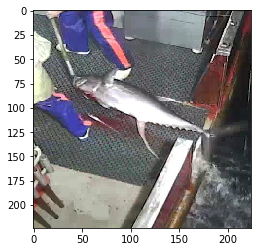

In [6]:
im = Image.open(test_path + 'test_stg1/img_00697.jpg').resize((640, 360))
test_x = np.array(im).reshape(1, 3, 360, 640)
coords = get_bb_pred(test_x.reshape(1, 3, 360, 640))

x = coords[2]
y = coords[3]
cropped = im.crop((x, y, x + cropsize, y + cropsize))

plt.imshow(cropped)

### Generate Preds

In [17]:
def generate_preds(model):
    fish_detector = Vgg16BN(size=(270, 480), n_classes=2, lr=0.001,
                            batch_size=batch_size, dropout=dropout)
    fish_detector.build()
    fish_detector.model.load_weights(fish_detector_path)

    nofish_prob, filenames = fish_detector.test(test_path, nb_test_samples, aug=nb_aug)
    nofish_prob = nofish_prob[:, 1]
    
    predictions = []
    
    for ix, fn in enumerate(filenames):
        
        if ix % 100 == 0:
            print("Processing {0} of {1}".format(ix, len(filenames)))
        
        im_id = fn.split("/")[-1]
        im = Image.open(test_path + fn).resize((640, 360))
        test_x = np.array(im)
    
        # Nofish
        if nofish_prob[ix] > 0.5:
            alloc = (1. - nofish_prob[ix] / 7.)
            pred = np.array([alloc, alloc, alloc, alloc, nofish_prob[ix], alloc, alloc, alloc])
            predictions.append(pred)
            
        # Fish
        else:
            coords = get_bb_pred(test_x.reshape(1, 3, 360, 640))        
            x = coords[2]
            y = coords[3]

            cropped = im.crop((x, y, x + cropsize, y + cropsize))
            cropped.save("test_crop_viz/" + im_id)
            test_x = np.array(cropped).reshape(1, 3, cropsize, cropsize)
            weight = -1. * (nofish_prob[ix] - 1.)
            
            pred = model.predict(test_x)
            pred = weight * pred
            pred = np.insert(pred, 4, nofish_prob[ix], axis=1)
            predictions.append(pred)
    
    return np.array(predictions), filenames

In [19]:
def test(model_paths):   
                 
    print("----Predicting on {} model...".format("vggbn"))
    parent = models["vggbn"]
    model = parent.build()
    model.load_weights(model_paths["vggbn"][0])
    predictions, filenames = generate_preds(model)
    return predictions, filenames

predictions, filenames = test(model_paths)

----Predicting on vggbn model...


/home/robert/anaconda3/lib/python3.5/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode='max')
/home/robert/anaconda3/lib/python3.5/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode='max')
/home/robert/anaconda3/lib/python3.5/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode='max')


Found 1000 images belonging to 1 classes.
Processing 0 of 1000


/home/robert/anaconda3/lib/python3.5/site-packages/keras/backend/theano_backend.py:1505: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode='average_exc_pad')
/home/robert/anaconda3/lib/python3.5/site-packages/keras/backend/theano_backend.py:1505: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode='average_exc_pad')
/home/robert/anaconda3/lib/python3.5/site-packages/keras/backend/theano_backend.py:1505: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode='average_exc_pad')


Processing 100 of 1000
Processing 200 of 1000
Processing 300 of 1000
Processing 400 of 1000
Processing 500 of 1000
Processing 600 of 1000
Processing 700 of 1000
Processing 800 of 1000
Processing 900 of 1000


### Write Predictions to File

In [35]:
def write_submission(predictions, filenames):
    preds = np.vstack(predictions)
    preds = np.clip(preds, clip, 1-clip)
    sub_fn = submission_path + '{0}epoch_{1}aug_{2}clip_{3}runs'.format(nb_epoch, nb_aug, clip, nb_runs)
    
    for arch in archs:
        sub_fn += "_{}".format("vggbn")

    with open(sub_fn + '.csv', 'w') as f:
        print("Writing Predictions to CSV...")
        f.write('image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT\n')
        for i, image_name in enumerate(filenames):
            pred = ['%.6f' % p for p in preds[i, :]]
            f.write('%s,%s\n' % (os.path.basename(image_name), ','.join(pred)))
        print("Done.")

write_submission(predictions, filenames)

Writing Predictions to CSV...
Done.
